# Diagnostics

This notebook contains preliminary exploratory analysis performed to identify potential issues and limitations in the dataset of T-cell measurements. 

In [1]:
# Imports & setup
import os

import numpy as np

import re

import pandas as pd
from pandas import read_csv

import matplotlib.pyplot as plt
CB_COLOR_CYCLE = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', 
                  '#dede00']

import seaborn as sns

import scipy.stats as stats

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, SparsePCA
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (balanced_accuracy_score, r2_score, confusion_matrix, recall_score, 
                             roc_auc_score, average_precision_score, roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import plot_partial_dependence

import xgboost as xgb

import networkx as nx

from data_loader import construct_tcell_df, construct_mfi_df
from bootstrap_utils import (run_repeated_CV_XGB, boot_train_test_XGB, boot_train_test_LR, boot_train_test_random, 
                             boot_train_test_feature, boot_feature_selection, boot_feature_selection_LR)
from misc_utils import (print_perf_statistics, count_underexpressed_cells_assay, measure_CV_assay, measure_CV_IAC)
from plotting_utils import (parcoord_plot, plot_errorbars, parcoord_plot_sep, 
                            plot_hist_assay_by_tretament, plot_hist_assay_by_tretament_mfi, 
                            plot_corr_assay, plot_by_symptoms, plot_assay_ecdfs, plot_large_corr_mat)

In [2]:
sensitivity = recall_score

def specificity(y_true, y_pred):
    return balanced_accuracy_score(y_true, y_pred) * 2 - recall_score(y_true, y_pred)

In [3]:
# Load the data
# NB: low_memory=False is needed to deal with mixed type variables
df = read_csv(filepath_or_buffer="CoV-ETH_190721_to_JV_190721.csv", low_memory=False)

# Inclusion criteria: 
included = np.logical_or(df['Proband_in_miltenyi_positive_negative_consolidated'].values == 'positive', 
                        df['Proband_in_miltenyi_positive_negative_consolidated'].values == 'negative')

df_included = df.loc[np.squeeze(np.argwhere(included)),]

rdata = df_included.values
rdata_cols = list(df_included.columns)

ndata, ndata_cols = construct_tcell_df(df_included, feature_type='', scale=False)
ndata_mfi, ndata_mfi_cols = construct_mfi_df(df_included, scale=False)

In [4]:
# Define consolidated response
consolidated_response_S10 = np.logical_and(df_included['RB50_IgG_S10'].values >= 50, 
                        np.logical_or(df_included['NP50_IgG_S10'].values >= 5.0, 
                                      np.logical_or(df_included['S150_IgG_S10'].values >= 20, 
                                                    df_included['S250_IgG_S10'].values >= 5.0)))
consolidated_response_S11 = np.logical_and(df_included['RB50_IgG_S11'].values >= 50, 
                        np.logical_or(df_included['NP50_IgG_S11'].values >= 5.0, 
                                      np.logical_or(df_included['S150_IgG_S11'].values >= 20, 
                                                    df_included['S250_IgG_S11'].values >= 5.0)))
consolidated_response_ = np.logical_or(consolidated_response_S10, consolidated_response_S11)

RBn_only_S10 = np.logical_and(df_included['RB50_IgG_S10'].values >= 50, 
                        np.logical_not(np.logical_or(df_included['NP50_IgG_S10'].values >= 5.0, 
                                      np.logical_or(df_included['S150_IgG_S10'].values >=20, 
                                                    df_included['S250_IgG_S10'].values >= 5.0))))
RBn_only_S11 = np.logical_and(df_included['RB50_IgG_S11'].values >= 50, 
                        np.logical_not(np.logical_or(df_included['NP50_IgG_S11'].values >= 5.0, 
                                      np.logical_or(df_included['S150_IgG_S11'].values >= 20, 
                                                    df_included['S250_IgG_S11'].values >= 5.0))))
RBn_only = np.logical_and(RBn_only_S10, RBn_only_S11)
wo_blocking = df_included['BoB_all_IC50_consolidated_S10'].values >= 10

consolidated_response = np.copy(consolidated_response_).astype('U32')
consolidated_response[consolidated_response_] = 'positive'
consolidated_response[np.logical_not(consolidated_response_)] = 'negative'
consolidated_response[RBn_only] = 'borderline'

### Cohort Variance across Assays & Treatments

#### TNF Assay

Total raw assay columns: 30
Cov-2 mix raw assay columns: 6
Protein N raw assay columns: 6
Protein S1 raw assay columns: 6
Protein S raw assay columns: 6
Protein M raw assay columns: 6
Total normalised assay columns: 30
Cov-2 mix normalised assay columns: 6
Protein N normalised assay columns: 6
Protein S1 normalised assay columns: 6
Protein S normalised assay columns: 6
Protein M normalised assay columns: 6


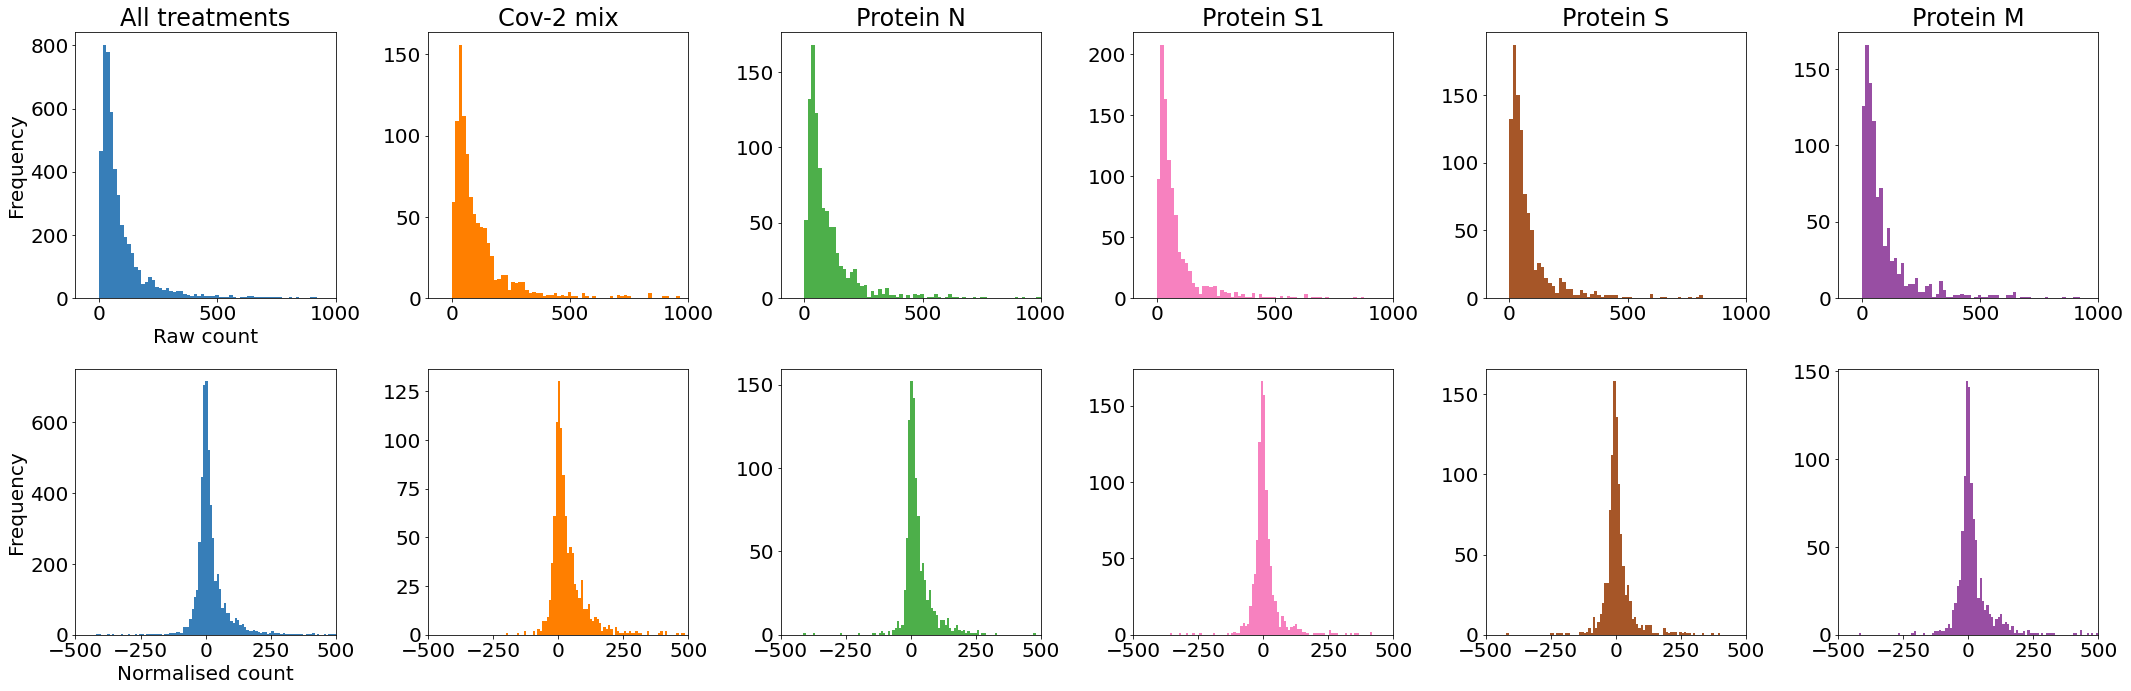

In [5]:
# TNF counts
plt.rcParams.update({'font.size': 20})

plot_hist_assay_by_tretament(rdata=rdata, rdata_cols=rdata_cols, ndata=ndata, ndata_cols=ndata_cols, 
                             assay='TNF', dtype='count', dtype_name='count', 
                             bins=300, alpha=1.0, nrange=[-500, 500], rrange=[-100, 1000], 
                             savedir='hist_count_TNF.png')

Total raw assay columns: 30
Cov-2 mix raw assay columns: 6
Protein N raw assay columns: 6
Protein S1 raw assay columns: 6
Protein S raw assay columns: 6
Protein M raw assay columns: 6
Total normalised assay columns: 30
Cov-2 mix normalised assay columns: 6
Protein N normalised assay columns: 6
Protein S1 normalised assay columns: 6
Protein S normalised assay columns: 6
Protein M normalised assay columns: 6


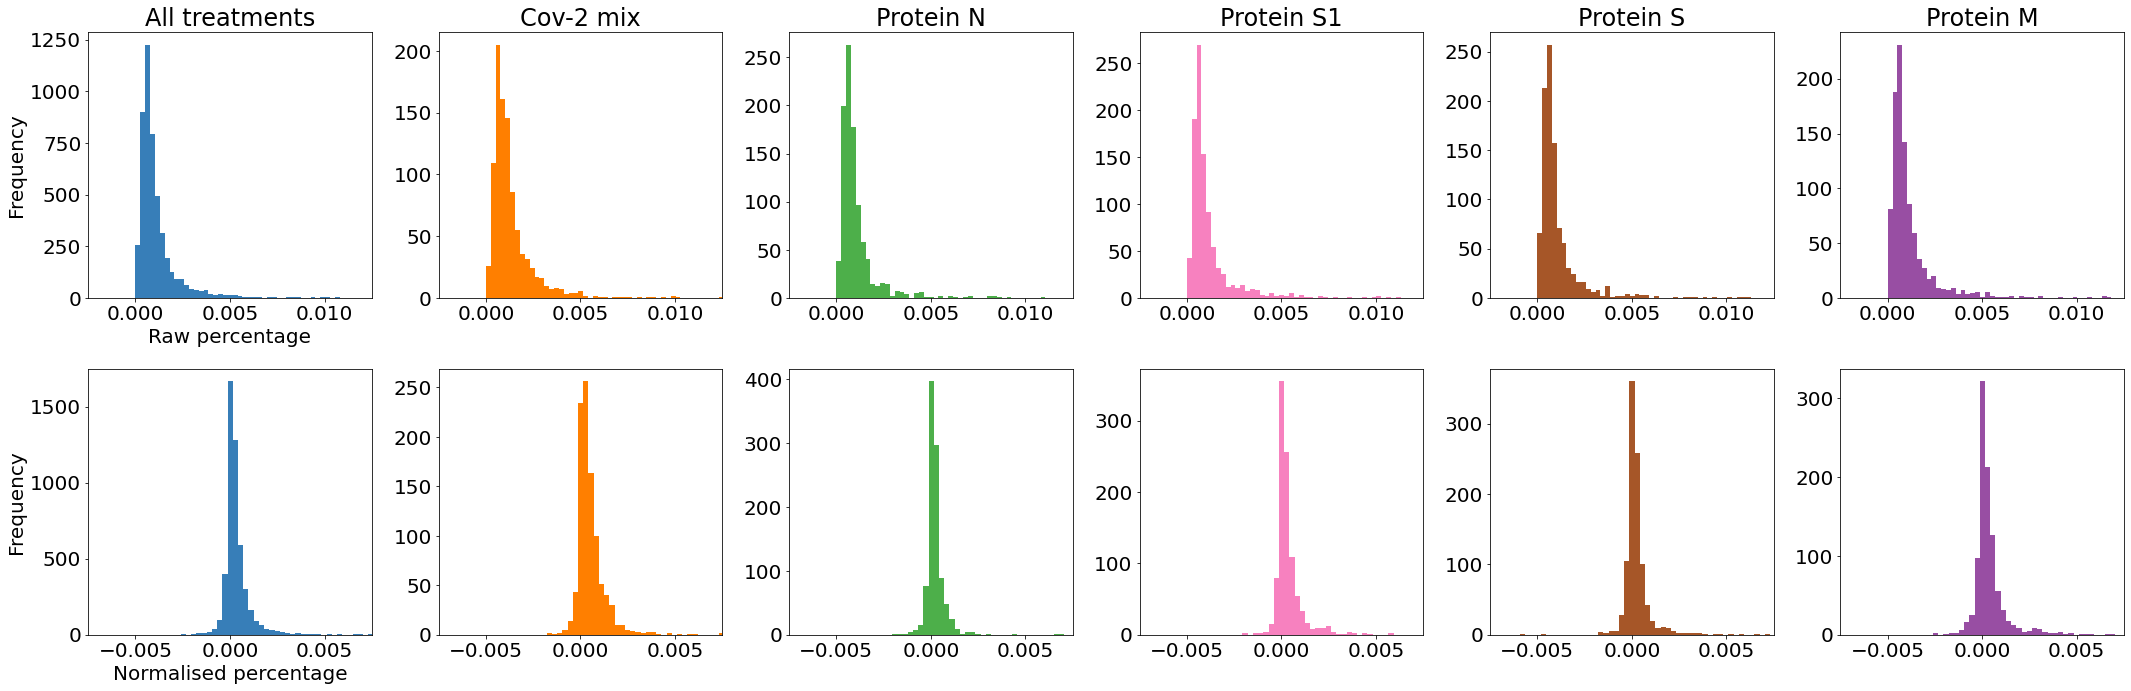

In [6]:
# TNF percentages
plot_hist_assay_by_tretament(rdata=rdata, rdata_cols=rdata_cols, ndata=ndata, ndata_cols=ndata_cols, 
                             assay='TNF', dtype='perc', dtype_name='percentage', 
                             bins=300, alpha=1.0, nrange=[-0.0075, 0.0075], rrange=[-0.0025, 0.0125], 
                             savedir='hist_perc_TNF.png')

Total raw assay columns: 30
Cov-2 mix raw assay columns: 6
Protein N raw assay columns: 6
Protein S1 raw assay columns: 6
Protein S raw assay columns: 6
Protein M raw assay columns: 6
Total normalised assay columns: 30
Cov-2 mix normalised assay columns: 6
Protein N normalised assay columns: 6
Protein S1 normalised assay columns: 6
Protein S normalised assay columns: 6
Protein M normalised assay columns: 6


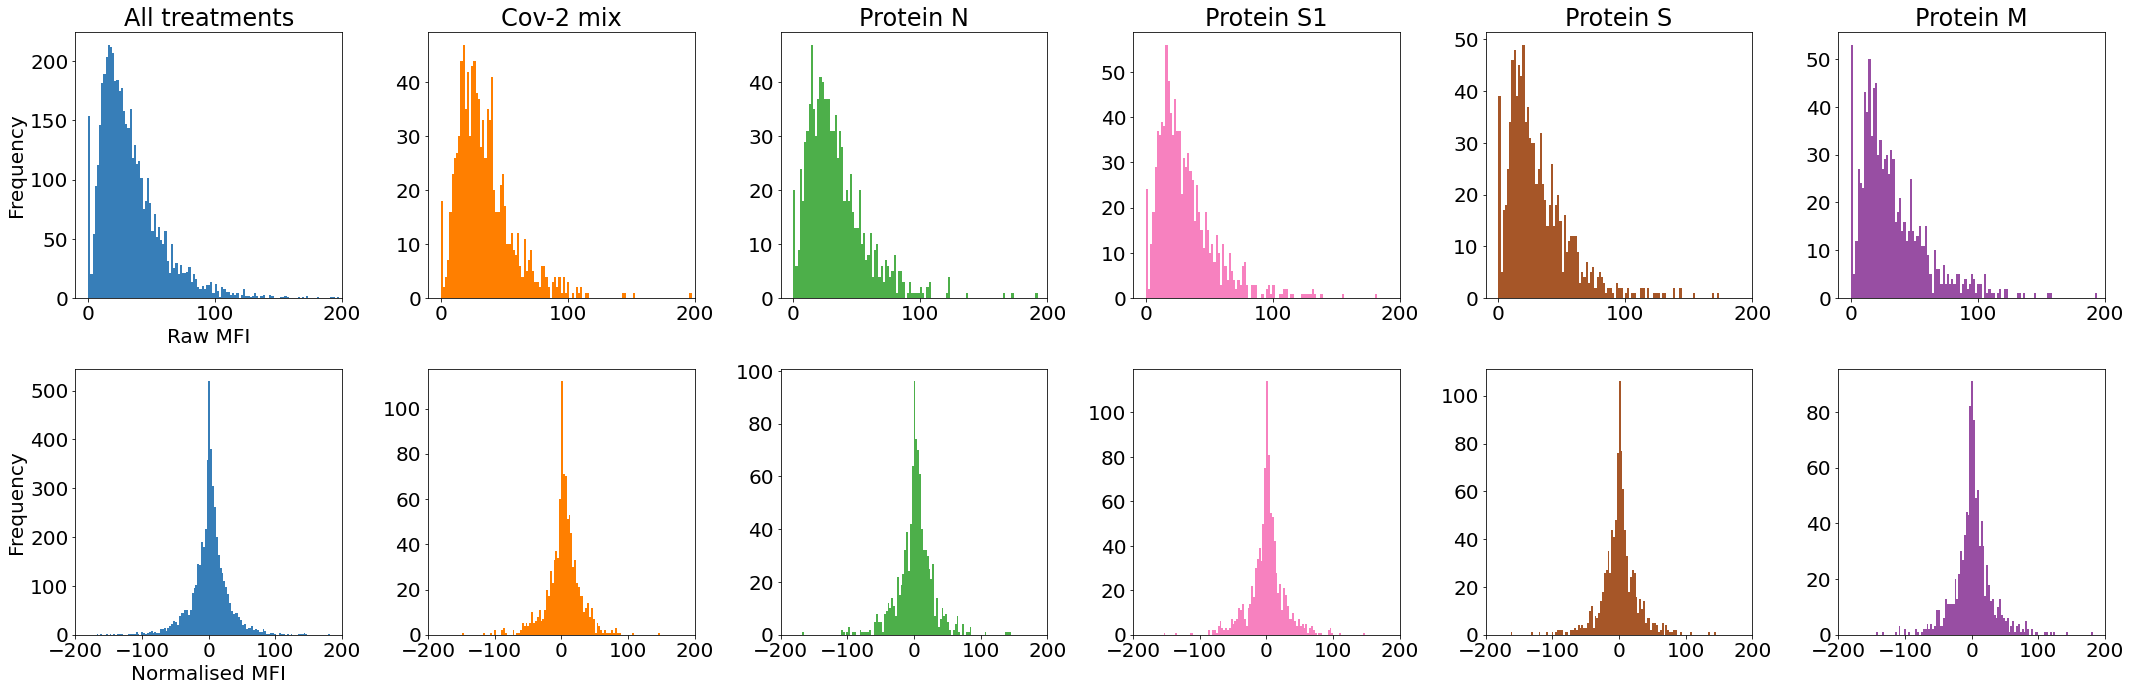

In [7]:
# TNF MFI
plot_hist_assay_by_tretament_mfi(rdata=rdata, rdata_cols=rdata_cols, ndata=ndata_mfi, ndata_cols=ndata_mfi_cols, 
                                 assay='TNF', bins=150, alpha=1.0, rrange=[-10, 200], nrange=[-200, 200], 
                                 savedir='hist_mfi_TNF.png')

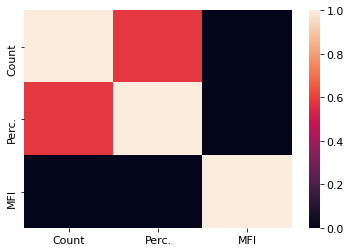

In [8]:
# TNF Correlation 
plt.rcParams.update({'font.size': 11})

plot_corr_assay(data=rdata, data_cols=rdata_cols, data_mfi=rdata, data_mfi_cols=rdata_cols, assay='TNF', 
                savedir='corr_TNF_r.png')

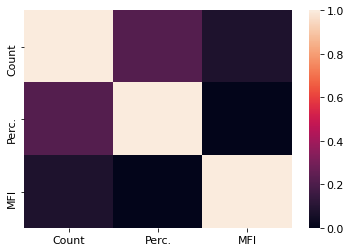

In [9]:
plot_corr_assay(data=ndata, data_cols=ndata_cols, data_mfi=ndata_mfi, data_mfi_cols=ndata_mfi_cols, assay='TNF',
               savedir='corr_TNF_n.png')

plt.rcParams.update({'font.size': 20})

#### IFN Assay

Total raw assay columns: 30
Cov-2 mix raw assay columns: 6
Protein N raw assay columns: 6
Protein S1 raw assay columns: 6
Protein S raw assay columns: 6
Protein M raw assay columns: 6
Total normalised assay columns: 30
Cov-2 mix normalised assay columns: 6
Protein N normalised assay columns: 6
Protein S1 normalised assay columns: 6
Protein S normalised assay columns: 6
Protein M normalised assay columns: 6


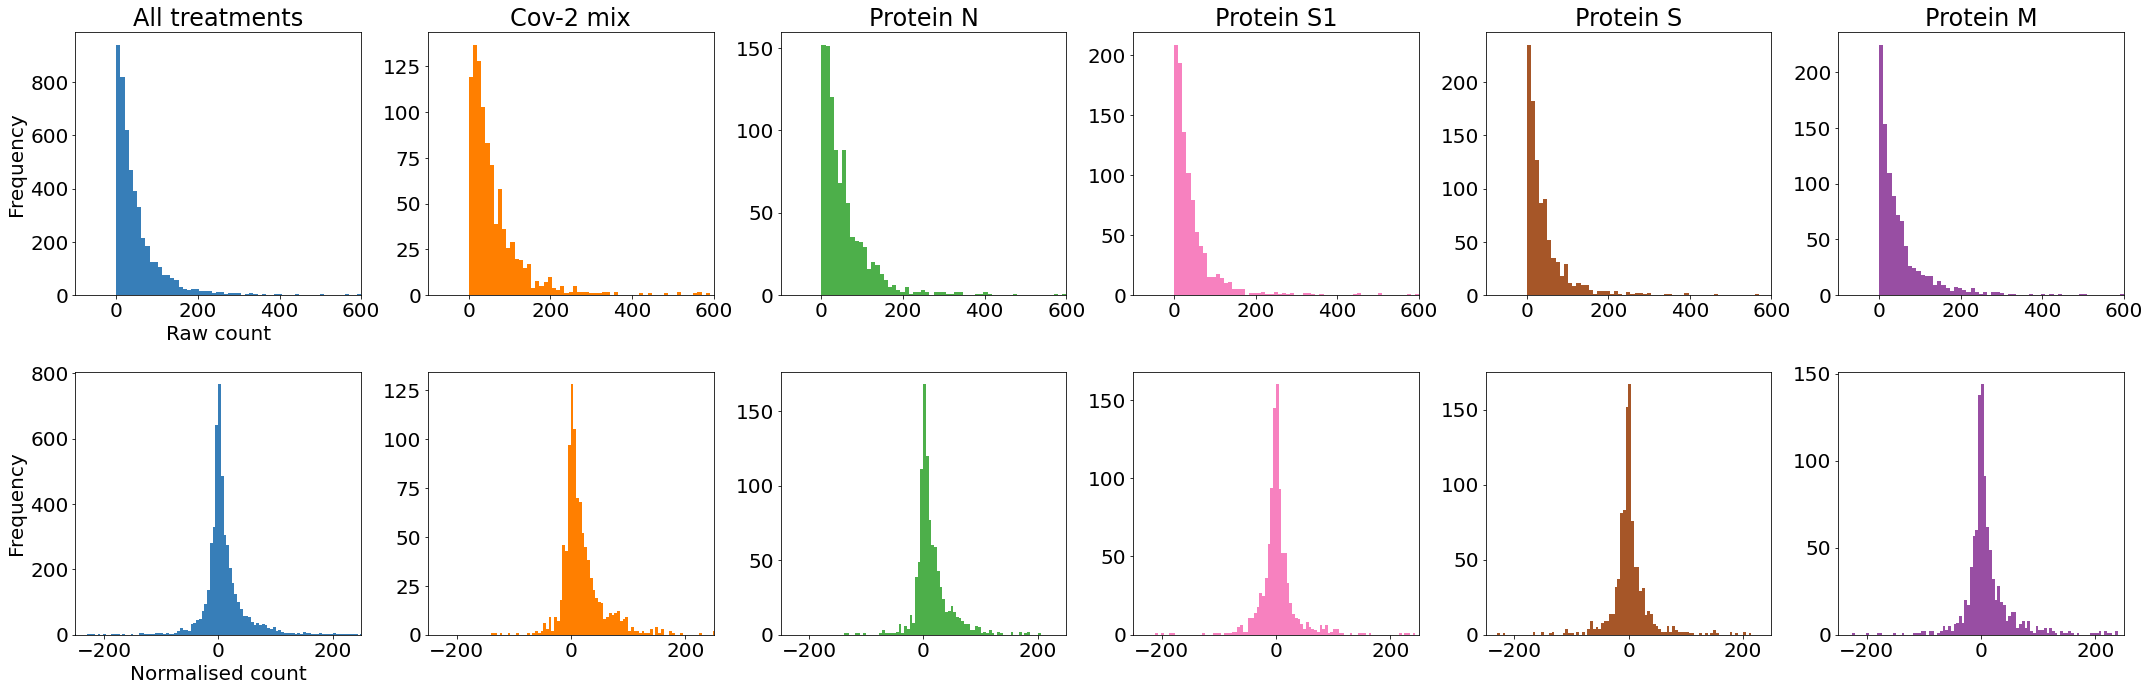

In [10]:
# IFN counts
plot_hist_assay_by_tretament(rdata=rdata, rdata_cols=rdata_cols, ndata=ndata, ndata_cols=ndata_cols, 
                             assay='IFN', dtype='count', dtype_name='count', 
                             bins=300, alpha=1.0, nrange=[-250, 250], rrange=[-100, 600], 
                             savedir='hist_count_IFN.png')

Total raw assay columns: 30
Cov-2 mix raw assay columns: 6
Protein N raw assay columns: 6
Protein S1 raw assay columns: 6
Protein S raw assay columns: 6
Protein M raw assay columns: 6
Total normalised assay columns: 30
Cov-2 mix normalised assay columns: 6
Protein N normalised assay columns: 6
Protein S1 normalised assay columns: 6
Protein S normalised assay columns: 6
Protein M normalised assay columns: 6


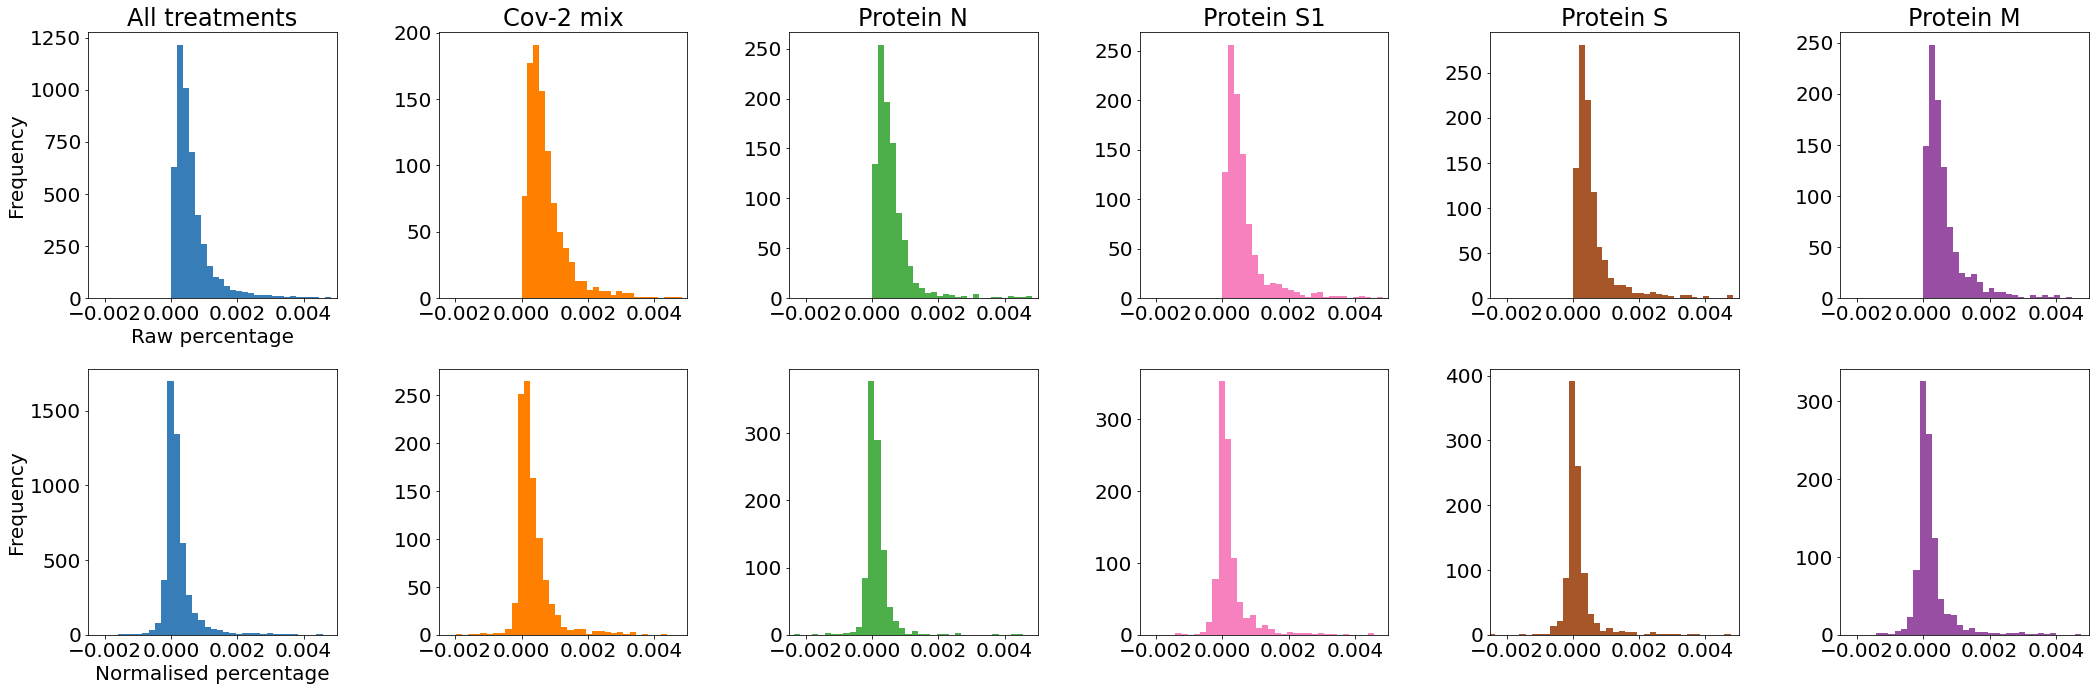

In [11]:
# IFN percentage
plot_hist_assay_by_tretament(rdata=rdata, rdata_cols=rdata_cols, ndata=ndata, ndata_cols=ndata_cols, 
                             assay='IFN', dtype='perc', dtype_name='percentage', 
                             bins=400, alpha=1.0, nrange=[-0.0025, 0.005], rrange=[-0.0025, 0.005], 
                             savedir='hist_perc_IFN.png')

Total raw assay columns: 30
Cov-2 mix raw assay columns: 6
Protein N raw assay columns: 6
Protein S1 raw assay columns: 6
Protein S raw assay columns: 6
Protein M raw assay columns: 6
Total normalised assay columns: 30
Cov-2 mix normalised assay columns: 6
Protein N normalised assay columns: 6
Protein S1 normalised assay columns: 6
Protein S normalised assay columns: 6
Protein M normalised assay columns: 6


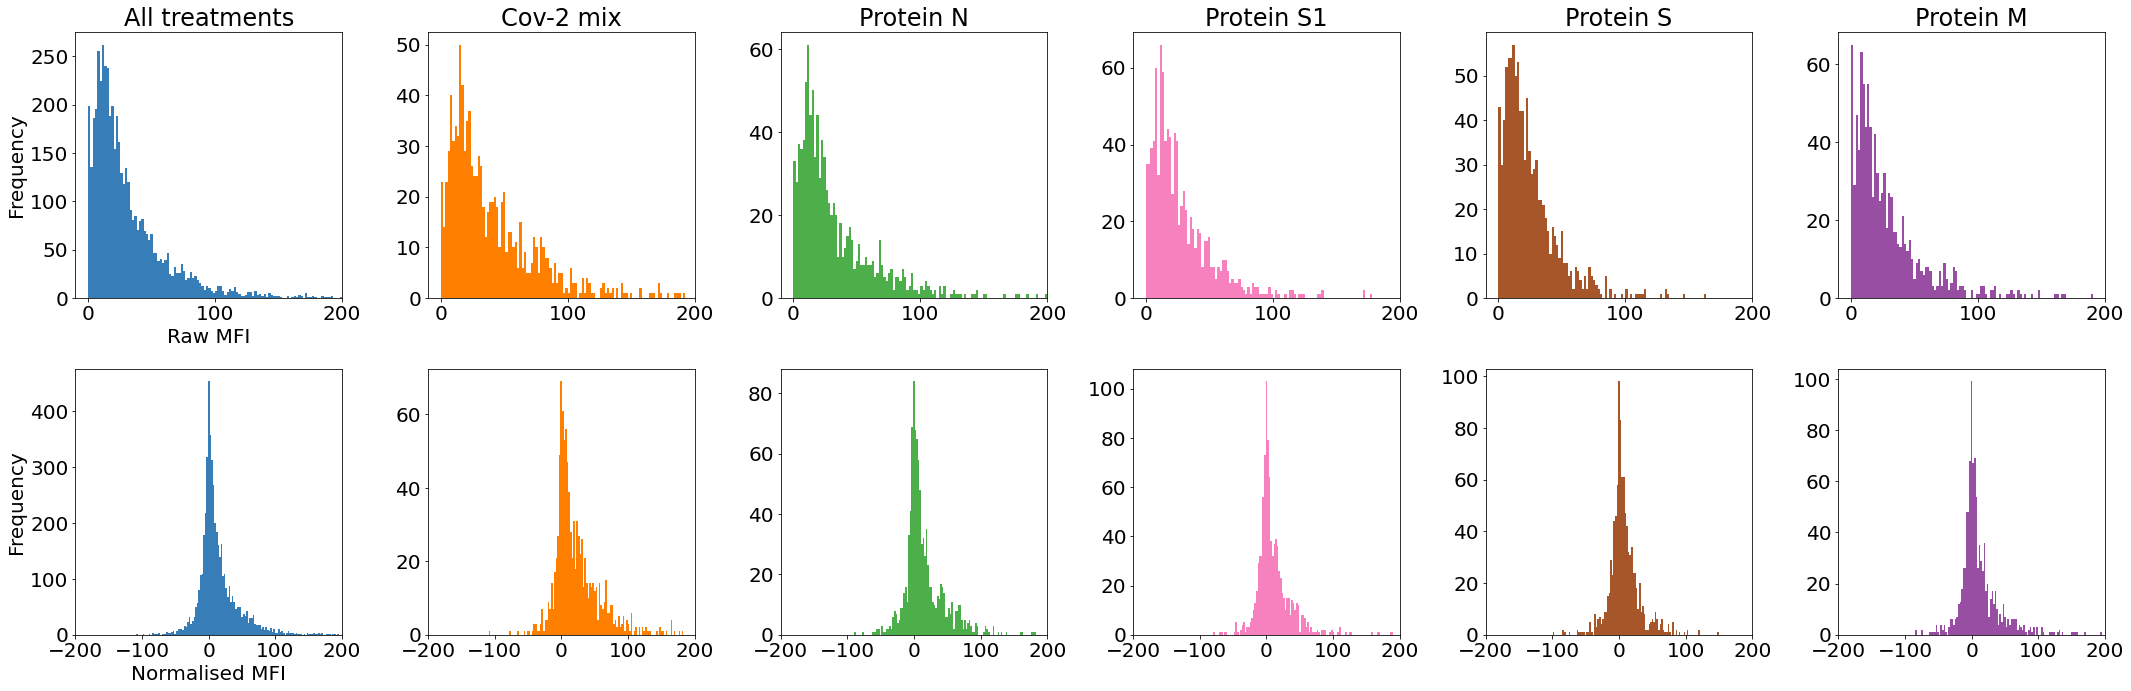

In [12]:
# IFN MFI
plot_hist_assay_by_tretament_mfi(rdata=rdata, rdata_cols=rdata_cols, ndata=ndata_mfi, ndata_cols=ndata_mfi_cols, 
                                 assay='IFN', bins=150, alpha=1.0, rrange=[-10, 200], nrange=[-200, 200], 
                                 savedir='hist_mfi_IFN.png')

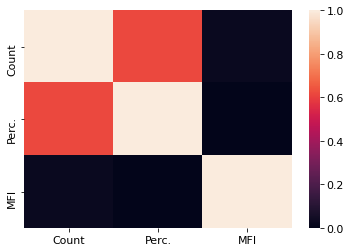

In [13]:
# IFN Correlation 
plt.rcParams.update({'font.size': 11})

plot_corr_assay(data=rdata, data_cols=rdata_cols, data_mfi=rdata, data_mfi_cols=rdata_cols, assay='IFN', 
                savedir='corr_IFN_r.png')

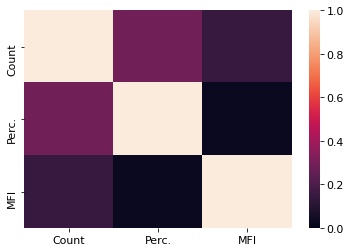

In [14]:
plot_corr_assay(data=ndata, data_cols=ndata_cols, data_mfi=ndata_mfi, data_mfi_cols=ndata_mfi_cols, assay='IFN', 
                savedir='corr_IFN_n.png')

plt.rcParams.update({'font.size': 20})

#### IL2 Assay

Total raw assay columns: 30
Cov-2 mix raw assay columns: 6
Protein N raw assay columns: 6
Protein S1 raw assay columns: 6
Protein S raw assay columns: 6
Protein M raw assay columns: 6
Total normalised assay columns: 30
Cov-2 mix normalised assay columns: 6
Protein N normalised assay columns: 6
Protein S1 normalised assay columns: 6
Protein S normalised assay columns: 6
Protein M normalised assay columns: 6


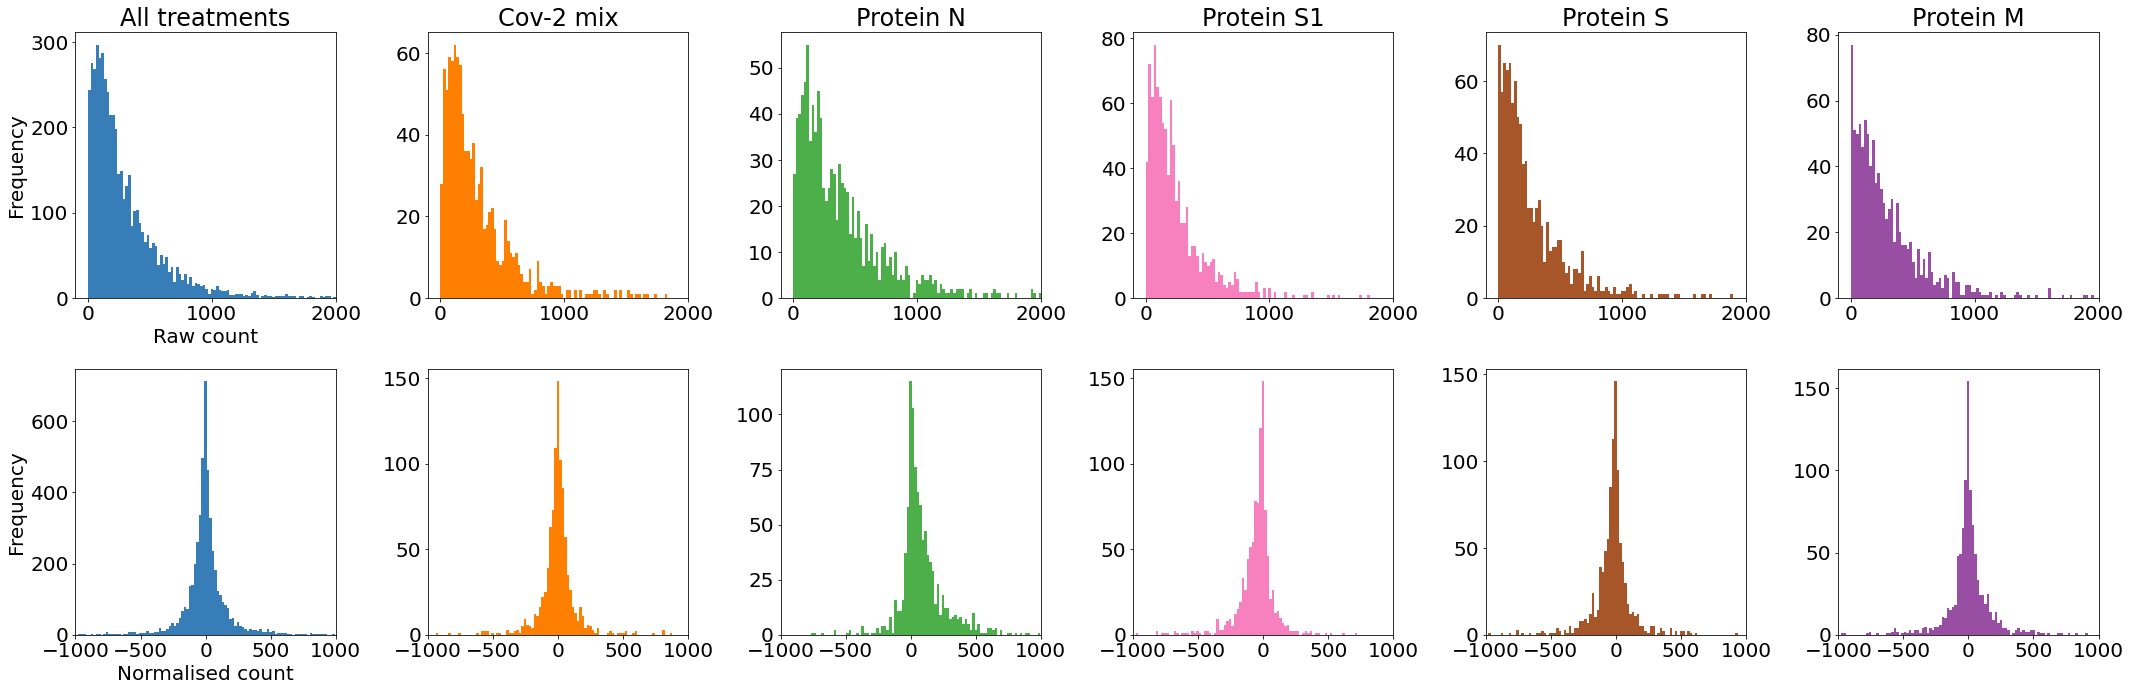

In [15]:
# IL2 counts
plot_hist_assay_by_tretament(rdata=rdata, rdata_cols=rdata_cols, ndata=ndata, ndata_cols=ndata_cols, 
                             assay='IL2', dtype='count', dtype_name='count', 
                             bins=300, alpha=1.0, nrange=[-1000, 1000], rrange=[-100, 2000], 
                             savedir='hist_count_IL2.png')

Total raw assay columns: 30
Cov-2 mix raw assay columns: 6
Protein N raw assay columns: 6
Protein S1 raw assay columns: 6
Protein S raw assay columns: 6
Protein M raw assay columns: 6
Total normalised assay columns: 30
Cov-2 mix normalised assay columns: 6
Protein N normalised assay columns: 6
Protein S1 normalised assay columns: 6
Protein S normalised assay columns: 6
Protein M normalised assay columns: 6


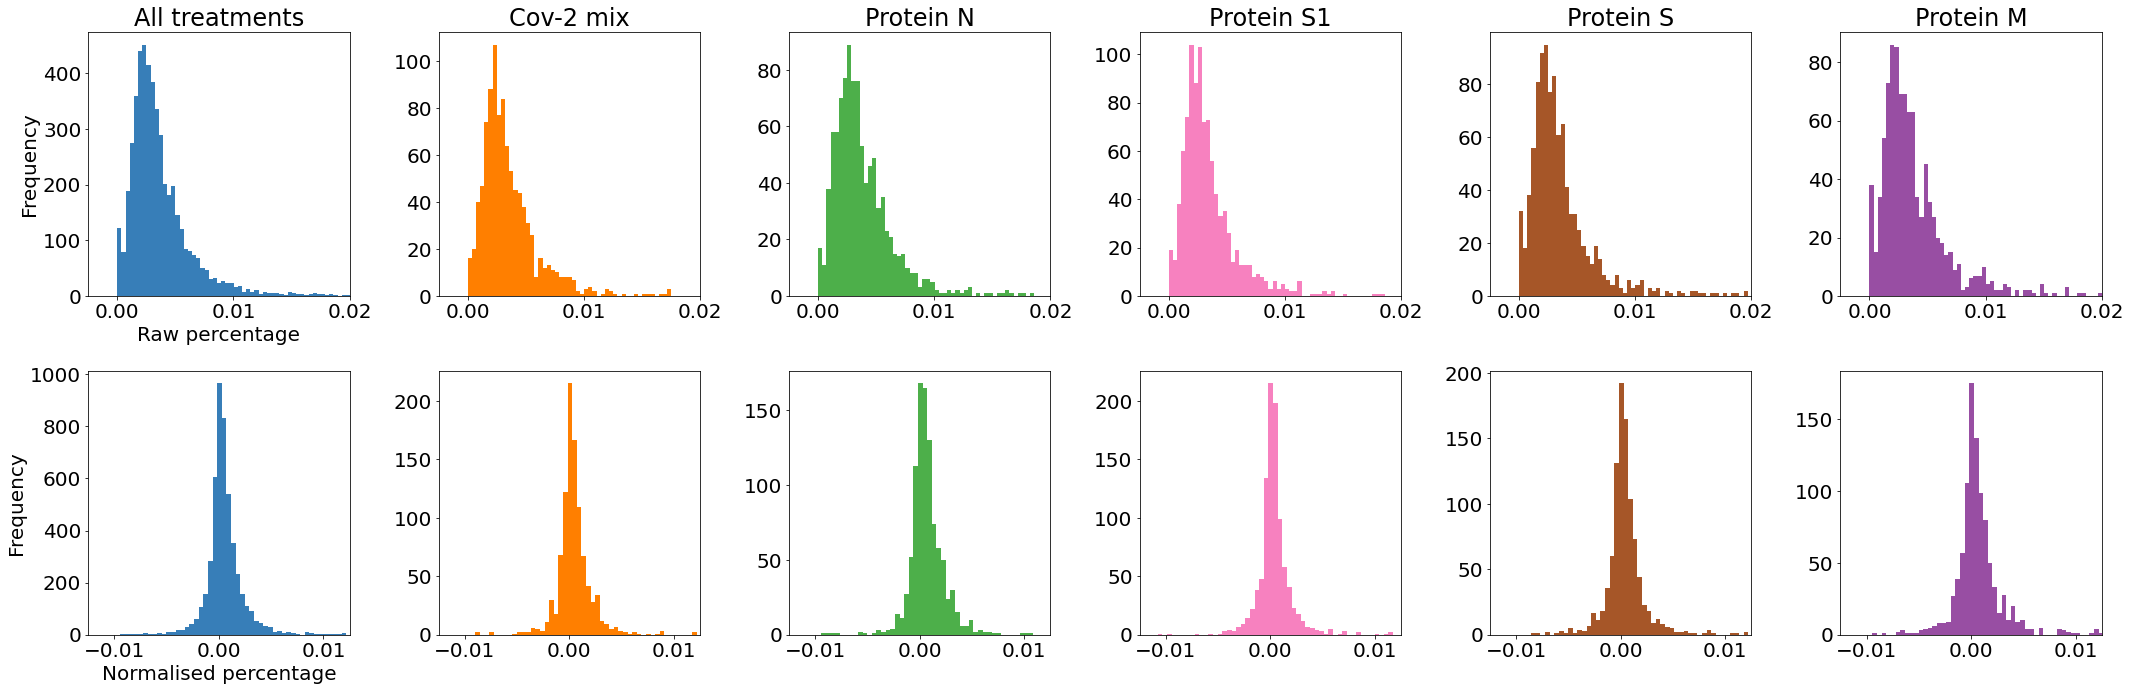

In [16]:
# IL2 percentages
plot_hist_assay_by_tretament(rdata=rdata, rdata_cols=rdata_cols, ndata=ndata, ndata_cols=ndata_cols, 
                             assay='IL2', dtype='perc', dtype_name='percentage', 
                             bins=400, alpha=1.0, nrange=[-0.0125, 0.0125], rrange=[-0.0025, 0.02], 
                             savedir='hist_perc_IL2.png')

Total raw assay columns: 30
Cov-2 mix raw assay columns: 6
Protein N raw assay columns: 6
Protein S1 raw assay columns: 6
Protein S raw assay columns: 6
Protein M raw assay columns: 6
Total normalised assay columns: 30
Cov-2 mix normalised assay columns: 6
Protein N normalised assay columns: 6
Protein S1 normalised assay columns: 6
Protein S normalised assay columns: 6
Protein M normalised assay columns: 6


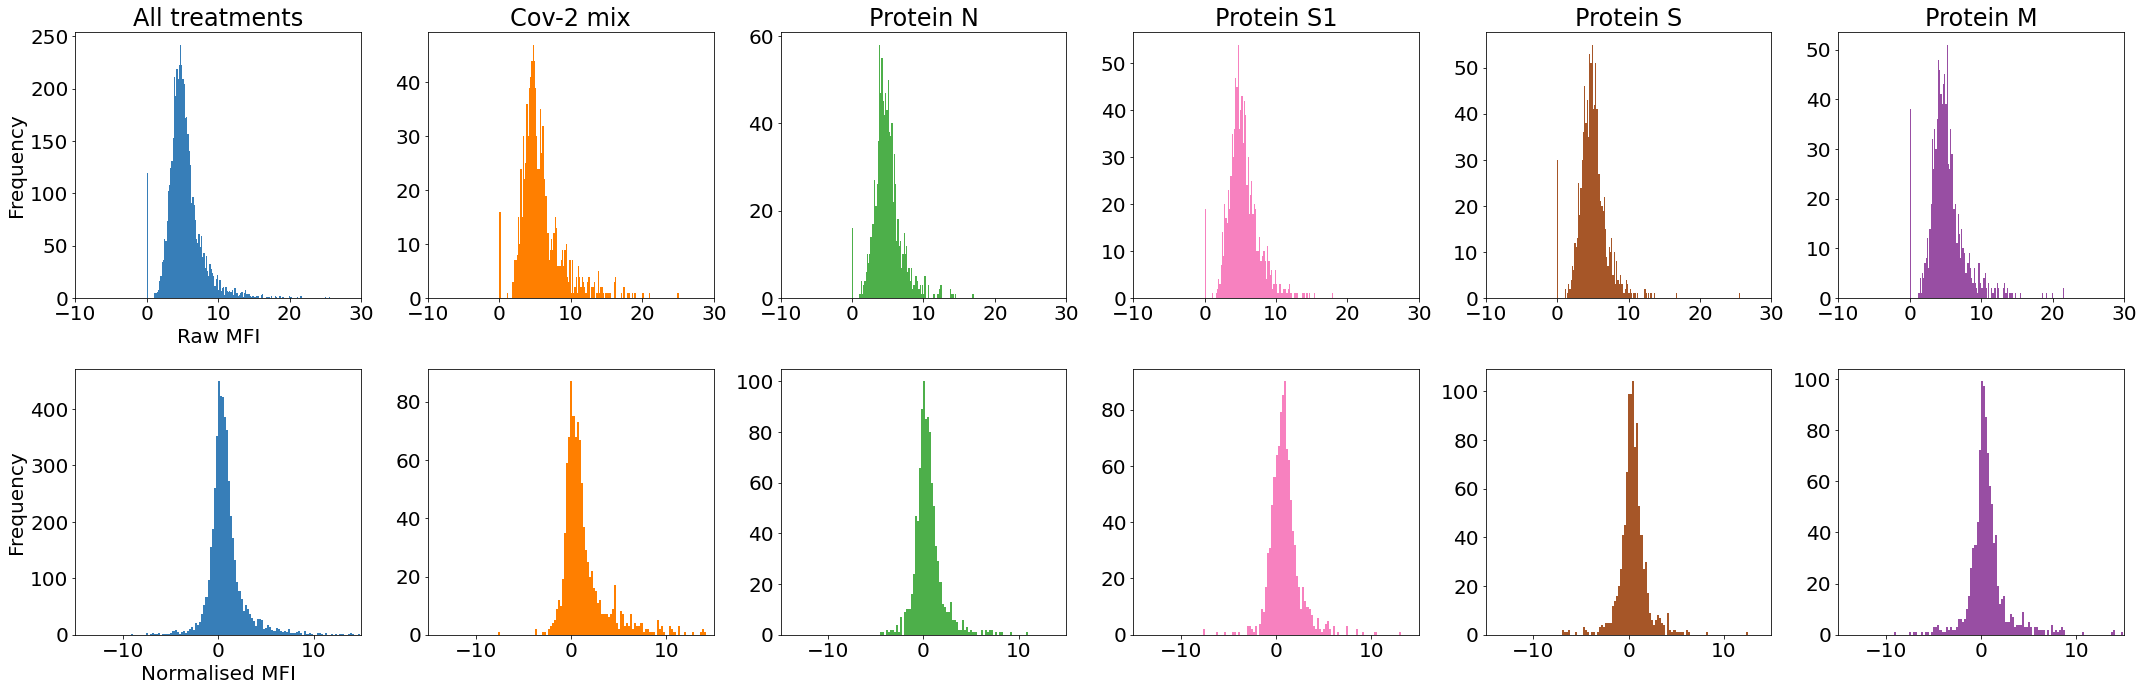

In [17]:
# IL2 MFI
ndata_mfi, ndata_mfi_cols = construct_mfi_df(df_included, scale=False)
plot_hist_assay_by_tretament_mfi(rdata=rdata, rdata_cols=rdata_cols, ndata=ndata_mfi, ndata_cols=ndata_mfi_cols, 
                                 assay='IL2', bins=150, alpha=1.0, rrange=[-10, 30], nrange=[-15, 15], 
                                 savedir='hist_mfi_IL2.png')

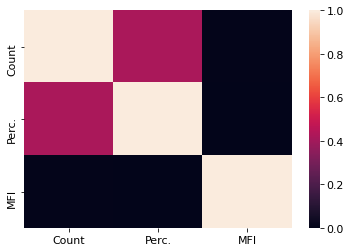

In [18]:
# IL2 Correlation 
plt.rcParams.update({'font.size': 11})

plot_corr_assay(data=rdata, data_cols=rdata_cols, data_mfi=rdata, data_mfi_cols=rdata_cols, assay='IL2', 
                savedir='corr_IL2_r.png')

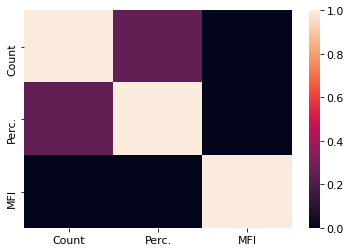

In [19]:
plot_corr_assay(data=ndata, data_cols=ndata_cols, data_mfi=ndata_mfi, data_mfi_cols=ndata_mfi_cols, assay='IL2', 
                savedir='corr_IL2_n.png')

plt.rcParams.update({'font.size': 20})

#### CD154 Assay

Total raw assay columns: 30
Cov-2 mix raw assay columns: 6
Protein N raw assay columns: 6
Protein S1 raw assay columns: 6
Protein S raw assay columns: 6
Protein M raw assay columns: 6
Total normalised assay columns: 30
Cov-2 mix normalised assay columns: 6
Protein N normalised assay columns: 6
Protein S1 normalised assay columns: 6
Protein S normalised assay columns: 6
Protein M normalised assay columns: 6


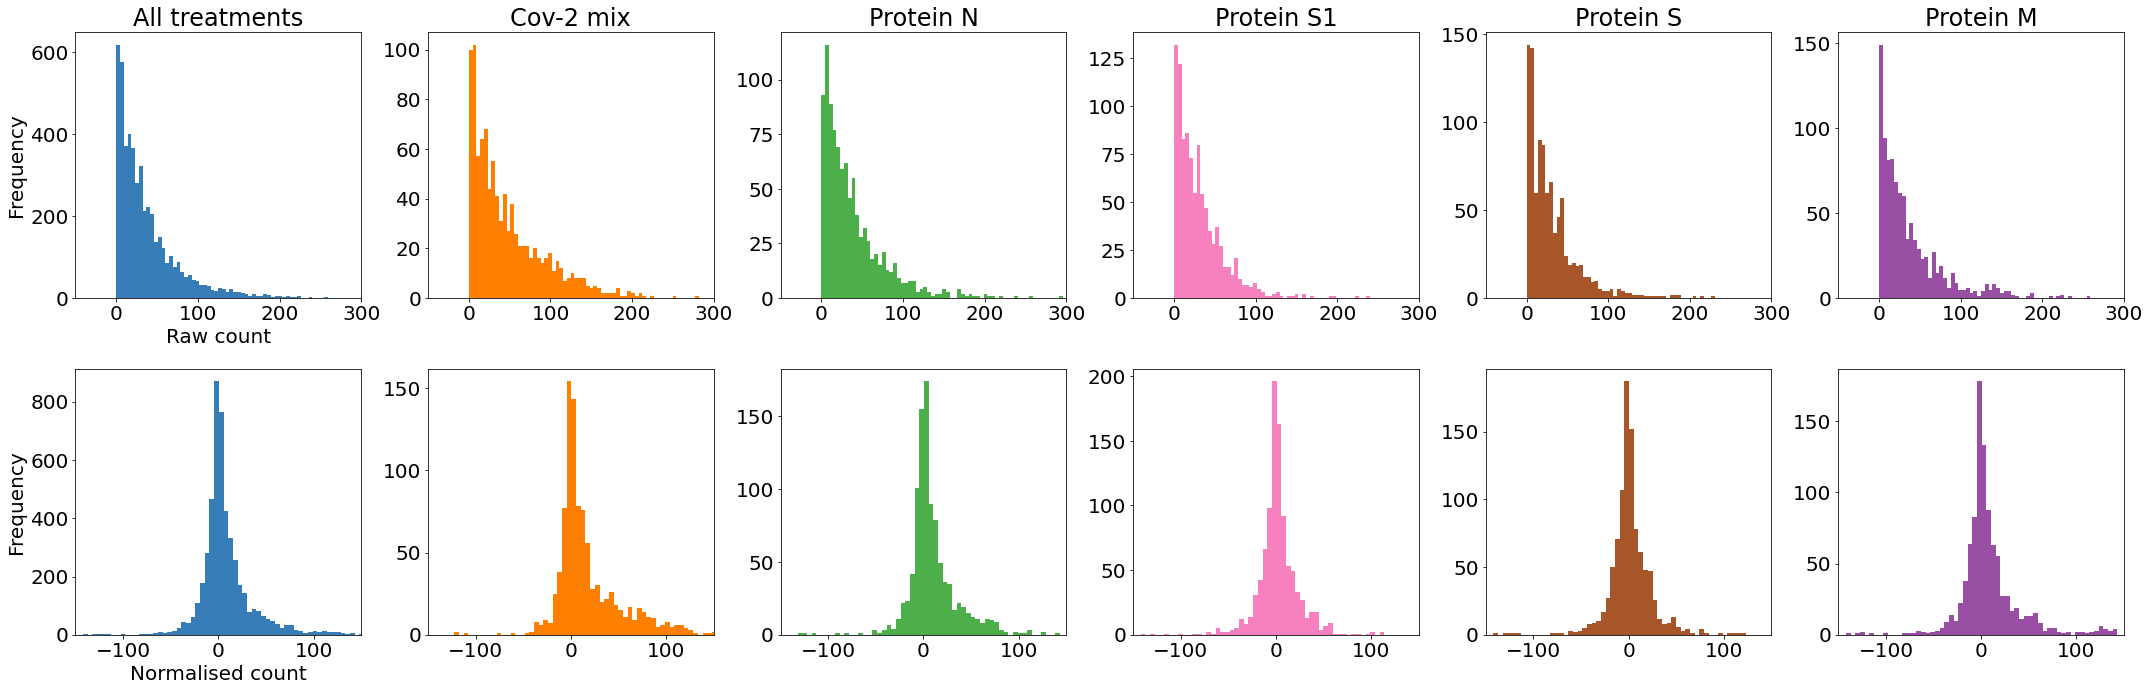

In [20]:
# CD154 counts
plot_hist_assay_by_tretament(rdata=rdata, rdata_cols=rdata_cols, ndata=ndata, ndata_cols=ndata_cols, 
                             assay='CD154', dtype='count', dtype_name='count', 
                             bins=300, alpha=1.0, nrange=[-150, 150], rrange=[-50, 300], 
                             savedir='hist_count_CD154.png')

Total raw assay columns: 30
Cov-2 mix raw assay columns: 6
Protein N raw assay columns: 6
Protein S1 raw assay columns: 6
Protein S raw assay columns: 6
Protein M raw assay columns: 6
Total normalised assay columns: 30
Cov-2 mix normalised assay columns: 6
Protein N normalised assay columns: 6
Protein S1 normalised assay columns: 6
Protein S normalised assay columns: 6
Protein M normalised assay columns: 6


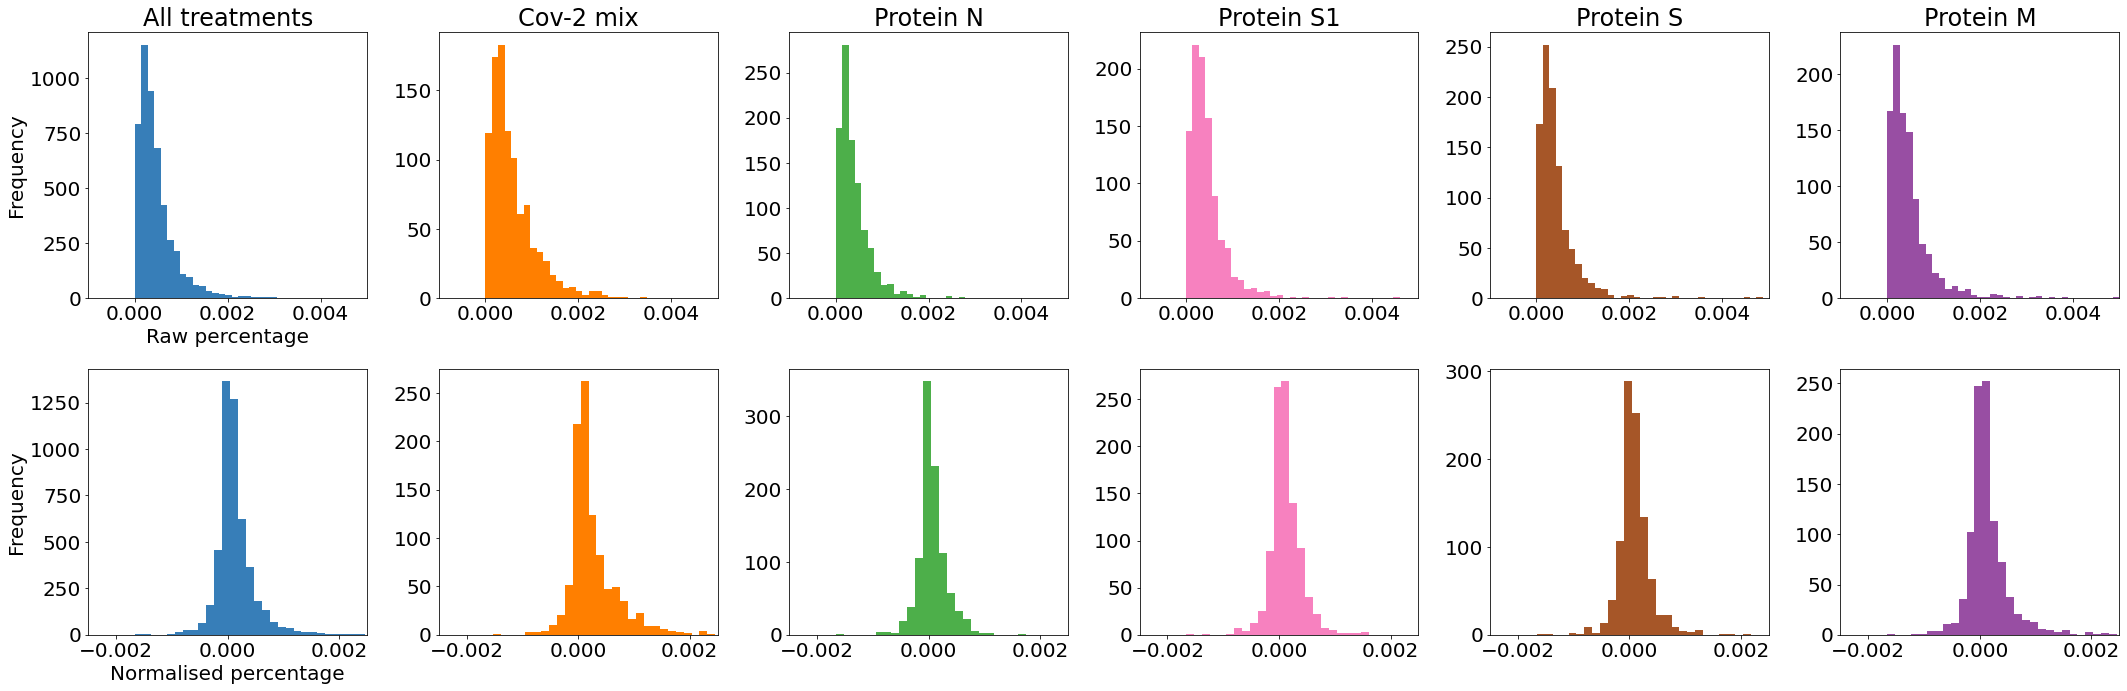

In [21]:
# CD154 percentages
plot_hist_assay_by_tretament(rdata=rdata, rdata_cols=rdata_cols, ndata=ndata, ndata_cols=ndata_cols, 
                             assay='CD154', dtype='perc', dtype_name='percentage', 
                             bins=400, alpha=1.0, nrange=[-0.0025, 0.0025], rrange=[-0.001, 0.005], 
                             savedir='hist_perc_CD154.png')

Total raw assay columns: 30
Cov-2 mix raw assay columns: 6
Protein N raw assay columns: 6
Protein S1 raw assay columns: 6
Protein S raw assay columns: 6
Protein M raw assay columns: 6
Total normalised assay columns: 30
Cov-2 mix normalised assay columns: 6
Protein N normalised assay columns: 6
Protein S1 normalised assay columns: 6
Protein S normalised assay columns: 6
Protein M normalised assay columns: 6


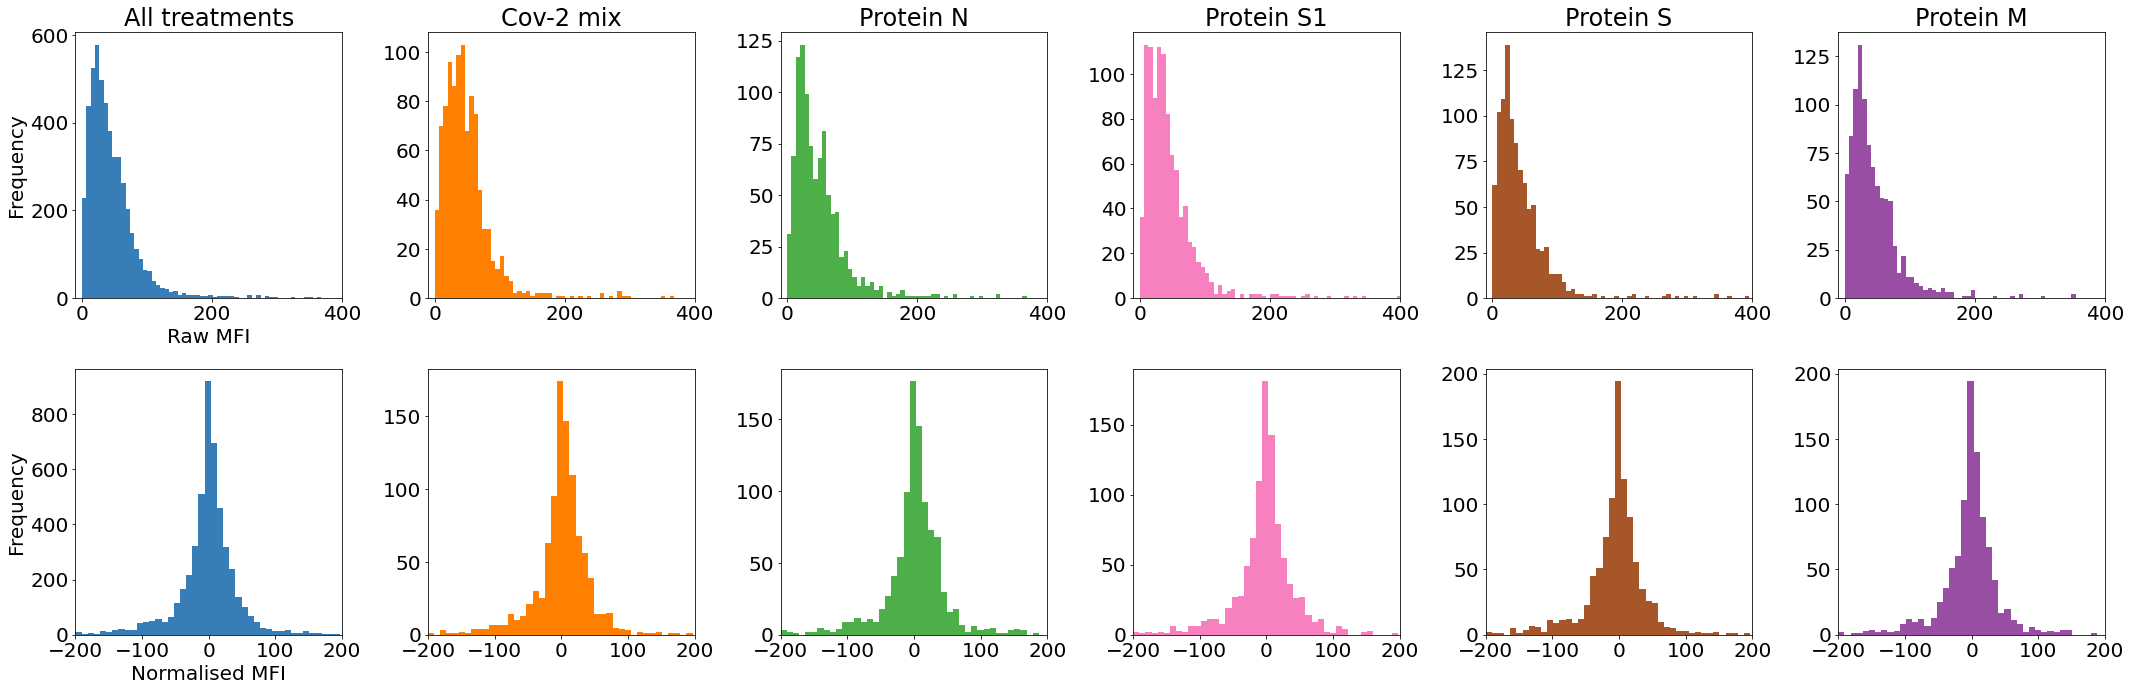

In [22]:
# CD154 MFI
ndata_mfi, ndata_mfi_cols = construct_mfi_df(df_included, scale=False)
plot_hist_assay_by_tretament_mfi(rdata=rdata, rdata_cols=rdata_cols, ndata=ndata_mfi, ndata_cols=ndata_mfi_cols, 
                                 assay='CD154', bins=150, alpha=1.0, rrange=[-10, 400], nrange=[-200, 200], 
                                 savedir='hist_mfi_CD154.png')

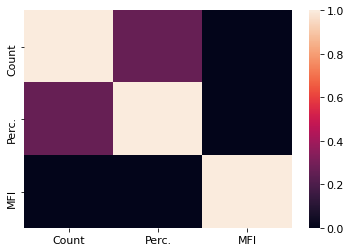

In [23]:
# CD154 Correlation 
plt.rcParams.update({'font.size': 11})

plot_corr_assay(data=rdata, data_cols=rdata_cols, data_mfi=rdata, data_mfi_cols=rdata_cols, assay='CD154', 
                savedir='corr_CD154_r.png')

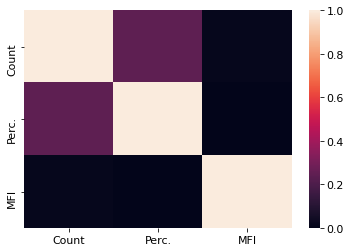

In [24]:
plot_corr_assay(data=ndata, data_cols=ndata_cols, data_mfi=ndata_mfi, data_mfi_cols=ndata_mfi_cols, assay='CD154', 
                savedir='corr_CD154_n.png')

plt.rcParams.update({'font.size': 20})

### Overall Correlation Matrix

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


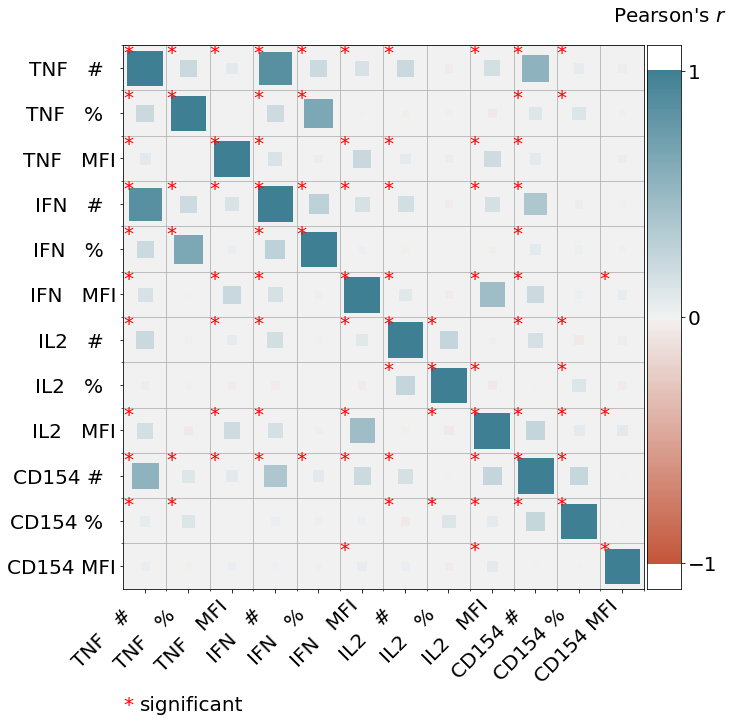

In [25]:
# Correlation matrix for different data types
ndata_mfi, ndata_cols_mfi = construct_mfi_df(df_included, scale=False)
plot_large_corr_mat(data=ndata, data_cols=ndata_cols, data_mfi=ndata_mfi, data_mfi_cols=ndata_mfi_cols, 
                    savedir='figures/dtype_corr_mat.jpg')

### Empirical Cumulative Distribution Functions Before and After Normalisation

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


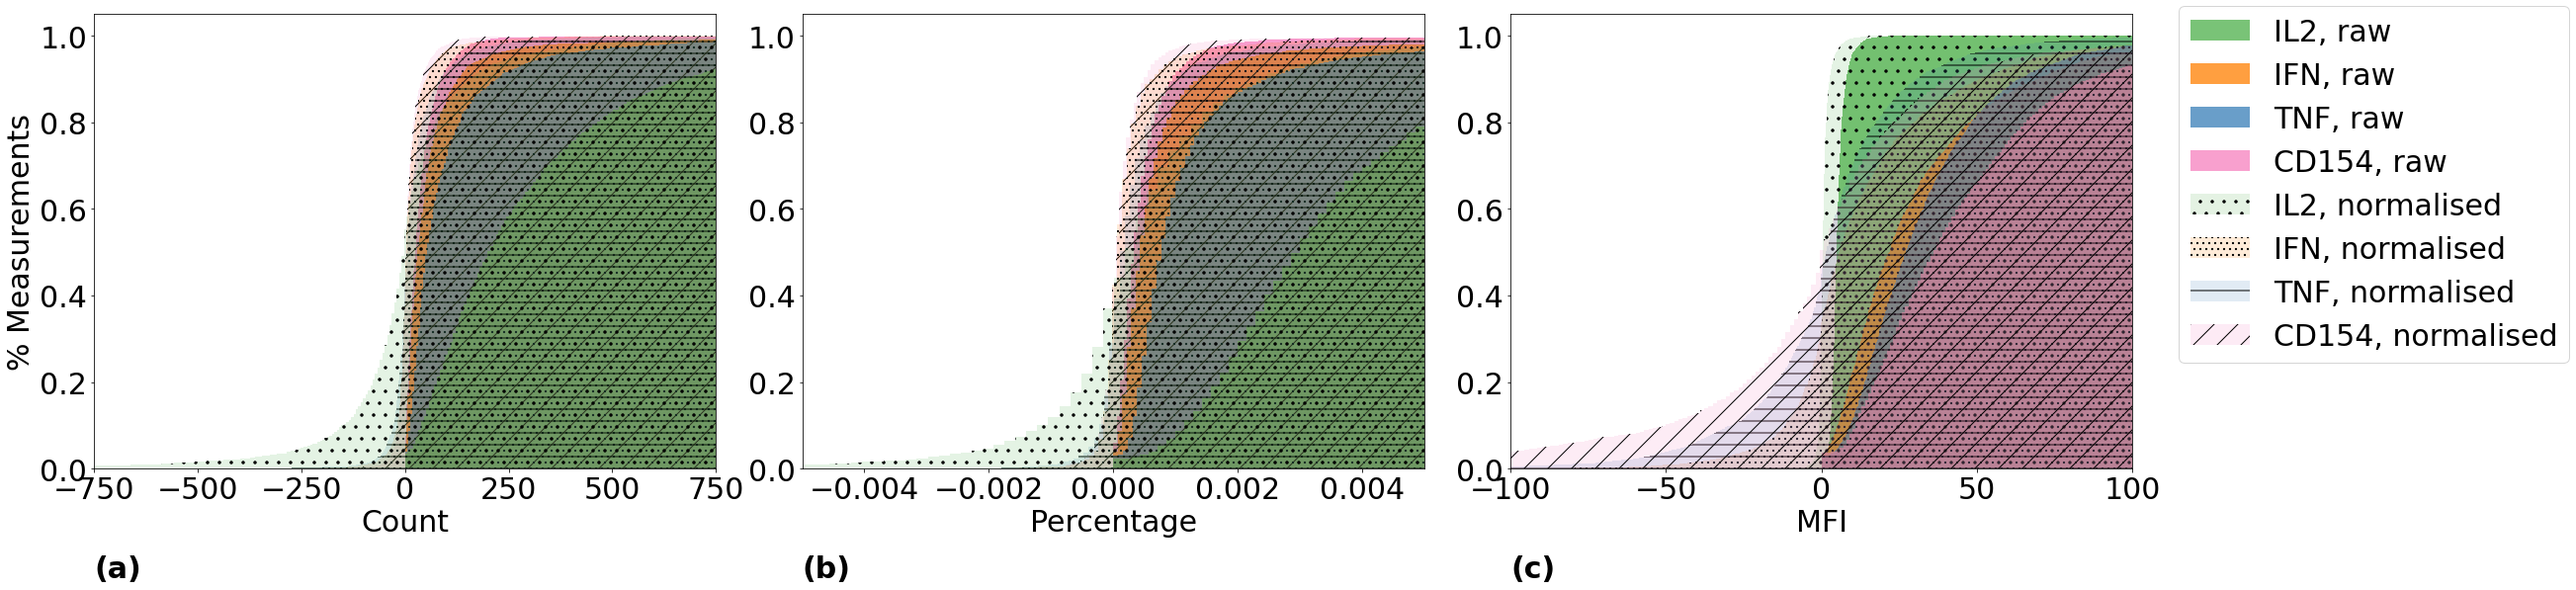

In [26]:
# Empirical CDFs
plot_assay_ecdfs(rdata=rdata, rdata_cols=rdata_cols, ndata=ndata, ndata_cols=ndata_cols,
                 ndata_mfi=ndata_mfi, ndata_cols_mfi=ndata_cols_mfi, bins=1000,
                savedir='./figures/ecdfs_assays.jpg')

### Low T-cell Measurements Across Assays

#### TNF

In [27]:
# Raw
count_underexpressed_cells_assay(data=rdata, data_cols=rdata_cols, assay='TNF', cutoff=20)

(0, 728, 4950)

In [28]:
# Normalised
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='TNF', cutoff=20)

(1899, 3277, 4950)

In [29]:
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='TNF', cutoff=20)[0] /\
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='TNF', cutoff=20)[2]

0.3836363636363636

In [30]:
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='TNF', cutoff=20)[1] /\
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='TNF', cutoff=20)[2]

0.6620202020202021

#### IFN

In [31]:
# Raw
count_underexpressed_cells_assay(data=rdata, data_cols=rdata_cols, assay='IFN', cutoff=20)

(0, 1682, 4950)

In [32]:
# Normalised
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='IFN', cutoff=20)

(1860, 3739, 4950)

In [33]:
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='IFN', cutoff=20)[0] /\
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='IFN', cutoff=20)[2]

0.37575757575757573

In [34]:
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='IFN', cutoff=20)[1] /\
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='IFN', cutoff=20)[2]

0.7553535353535353

#### IL2

In [35]:
# Raw
count_underexpressed_cells_assay(data=rdata, data_cols=rdata_cols, assay='IL2', cutoff=20)

(0, 230, 4950)

In [36]:
# Normalised
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='IL2', cutoff=20)

(2503, 3174, 4950)

In [37]:
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='IL2', cutoff=20)[0] /\
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='IL2', cutoff=20)[2]

0.5056565656565657

In [38]:
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='IL2', cutoff=20)[1] /\
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='IL2', cutoff=20)[2]

0.6412121212121212

#### CD154

In [39]:
# Raw
count_underexpressed_cells_assay(data=rdata, data_cols=rdata_cols, assay='CD154', cutoff=20)

(0, 2050, 4950)

In [40]:
# Normalised CD154
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='CD154', cutoff=20)

(1894, 3894, 4950)

In [41]:
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='CD154', cutoff=20)[0] /\
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='CD154', cutoff=20)[2]

0.38262626262626265

In [42]:
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='CD154', cutoff=20)[1] /\
count_underexpressed_cells_assay(data=ndata, data_cols=ndata_cols, assay='CD154', cutoff=20)[2]

0.7866666666666666

### Assessing Measurement Repeatbility Across Two Time Points

#### TNF

In [43]:
# All subjects

# Negative control treatment
print(str(measure_CV_assay(data=rdata[np.logical_not(RBn_only), :], 
                           data_cols=rdata_cols, 
                           assay='TNF', ctype='negative')) + "; " + 
      str(np.mean(measure_CV_assay(data=rdata[np.logical_not(RBn_only), :], 
                                   data_cols=rdata_cols, 
                                   assay='TNF', ctype='negative'))))

# Positive control treatment
print(str(measure_CV_assay(data=rdata[np.logical_not(RBn_only), :], 
                           data_cols=rdata_cols, 
                           assay='TNF', ctype='positive')) + "; " + 
      str(np.mean(measure_CV_assay(data=rdata[np.logical_not(RBn_only), :], 
                                   data_cols=rdata_cols, 
                                   assay='TNF', ctype='positive'))))

[0.30186865 0.33033269 0.35577663]; 0.3293259924123966
[0.40450095 0.4147812  0.41060303]; 0.40996172805054454


In [44]:
# Negative subjects only

# Negative control treatment
print(str(measure_CV_assay(data=rdata[consolidated_response == 'negative', :], data_cols=rdata_cols, 
                           assay='TNF', ctype='negative')) + "; " + 
      str(np.mean(measure_CV_assay(data=rdata[consolidated_response == 'negative', :], data_cols=rdata_cols, 
                                   assay='TNF', ctype='negative'))))

# Positive control treatment
print(str(measure_CV_assay(data=rdata[consolidated_response == 'negative', :], data_cols=rdata_cols, assay='TNF', 
                           ctype='positive')) + "; " + 
      str(np.mean(measure_CV_assay(data=rdata[consolidated_response == 'negative', :], data_cols=rdata_cols, 
                                   assay='TNF', ctype='positive'))))

[0.33343172 0.35241942 0.35536499]; 0.3470720409140666
[0.44754601 0.44370368 0.44114293]; 0.44413087256156464


#### IFN

In [45]:
# All subjects

# Negative control treatment
print(str(measure_CV_assay(data=rdata[np.logical_not(RBn_only), :], data_cols=rdata_cols, assay='IFN', 
                           ctype='negative')) + "; " + 
      str(np.mean(measure_CV_assay(data=rdata[np.logical_not(RBn_only), :], data_cols=rdata_cols, assay='IFN', 
                                   ctype='negative'))))

# Positive control treatment
print(str(measure_CV_assay(data=rdata[np.logical_not(RBn_only), :], data_cols=rdata_cols, assay='IFN', 
                           ctype='positive')) + "; " + 
      str(np.mean(measure_CV_assay(data=rdata[np.logical_not(RBn_only), :], data_cols=rdata_cols, assay='IFN', 
                                   ctype='positive'))))

[0.33322687 0.38025078 0.38943361]; 0.36763708713098836
[0.3901329  0.40150883 0.39364466]; 0.39509546168352205


In [46]:
# Negative subjects only

# Negative control treatment
print(str(measure_CV_assay(data=rdata[consolidated_response == 'negative', :], data_cols=rdata_cols, 
                           assay='IFN', ctype='negative')) + "; " + 
      str(np.mean(measure_CV_assay(data=rdata[consolidated_response == 'negative', :], data_cols=rdata_cols, 
                                   assay='IFN', ctype='negative'))))

# Positive control treatment
print(str(measure_CV_assay(data=rdata[consolidated_response == 'negative', :], data_cols=rdata_cols, assay='IFN', 
                           ctype='positive')) + "; " + 
      str(np.mean(measure_CV_assay(data=rdata[consolidated_response == 'negative', :], data_cols=rdata_cols, 
                                   assay='IFN', ctype='positive'))))

[0.34242707 0.4064768  0.40284019]; 0.38391468624561936
[0.42309734 0.45329702 0.4236453 ]; 0.4333465530558933


#### IL2

In [47]:
# All subjects

# Negative control treatment
print(str(measure_CV_assay(data=rdata[np.logical_not(RBn_only), :], data_cols=rdata_cols, assay='IL2', 
                           ctype='negative')) + "; " + 
      str(np.mean(measure_CV_assay(data=rdata[np.logical_not(RBn_only), :], data_cols=rdata_cols, assay='IL2', 
                                   ctype='negative'))))

# Positive control treatment
print(str(measure_CV_assay(data=rdata[np.logical_not(RBn_only), :], data_cols=rdata_cols, assay='IL2', 
                           ctype='positive')) + "; " + 
      str(np.mean(measure_CV_assay(data=rdata[np.logical_not(RBn_only), :], data_cols=rdata_cols, assay='IL2', 
                                   ctype='positive'))))

[0.33665768 0.3393732  0.41511528]; 0.3637153870784437
[0.41112004 0.43107209 0.40346497]; 0.4152190359823084


In [48]:
# Negative subjects only

# Negative control treatment
print(str(measure_CV_assay(data=rdata[consolidated_response == 'negative', :], data_cols=rdata_cols, assay='IL2', 
                           ctype='negative')) + "; " + 
      str(np.mean(measure_CV_assay(data=rdata[consolidated_response == 'negative', :], data_cols=rdata_cols, 
                                   assay='IL2', ctype='negative'))))

# Positive control treatment
print(str(measure_CV_assay(data=rdata[consolidated_response == 'negative', :], data_cols=rdata_cols, assay='IL2', 
                           ctype='positive')) + "; " + 
      str(np.mean(measure_CV_assay(data=rdata[consolidated_response == 'negative', :], data_cols=rdata_cols, 
                                   assay='IL2', ctype='positive'))))

[0.37033717 0.34284637 0.44486345]; 0.3860156637577965
[0.43842587 0.45062085 0.43837701]; 0.4424745772116963


#### CD154

In [49]:
# All subjects

# Negative control treatment
print(str(measure_CV_assay(data=rdata[np.logical_not(RBn_only), :], data_cols=rdata_cols, assay='CD154', 
                           ctype='negative')) + "; " + 
      str(np.mean(measure_CV_assay(data=rdata[np.logical_not(RBn_only), :], data_cols=rdata_cols, assay='CD154', 
                                   ctype='negative'))))

# Positive control treatment
print(str(measure_CV_assay(data=rdata[np.logical_not(RBn_only), :], data_cols=rdata_cols, assay='CD154', 
                           ctype='positive')) + "; " + 
      str(np.mean(measure_CV_assay(data=rdata, data_cols=rdata_cols, assay='CD154', ctype='positive'))))

[0.43363488 0.43789635 0.55393788]; 0.4751563699162585
[0.41544559 0.41438155 0.37418762]; 0.3872242442959508


In [50]:
# Negative subjects only

# Negative control treatment
print(str(measure_CV_assay(data=rdata[consolidated_response == 'negative', :], data_cols=rdata_cols, 
                           assay='CD154', ctype='negative')) + "; " + 
      str(np.mean(measure_CV_assay(data=rdata[consolidated_response == 'negative', :], data_cols=rdata_cols, 
                                   assay='CD154', ctype='negative'))))

# Positive control treatment
print(str(measure_CV_assay(data=rdata[consolidated_response == 'negative', :], data_cols=rdata_cols, 
                           assay='CD154', ctype='positive')) + "; " + 
      str(np.mean(measure_CV_assay(data=rdata[consolidated_response == 'negative', :], data_cols=rdata_cols, 
                                   assay='CD154', ctype='positive'))))

[0.46131929 0.43786551 0.58801722]; 0.4957340069601151
[0.43150637 0.42841944 0.38779134]; 0.415905716059787


### Assessing Measurement Repeatbility Across Single Donor Measurements

In [51]:
# Load the data
df_iac = read_csv(filepath_or_buffer="Data_Cells_SU_081220_an_JV_310321.csv", low_memory=False)
data_iac = df_iac.values
iac_cols = list(df_iac.columns)

#### TNF

In [52]:
cvs_iac_TNF_1, col_names_iac_TNF_1 = measure_CV_IAC(data_iac=data_iac, data_iac_cols=iac_cols, assay='TNF', 
                                                    treatment='#1')
cvs_iac_TNF_2, col_names_iac_TNF_2 = measure_CV_IAC(data_iac=data_iac, data_iac_cols=iac_cols, assay='TNF', 
                                                    treatment='#2')
cvs_iac_TNF_7, col_names_iac_TNF_7 = measure_CV_IAC(data_iac=data_iac, data_iac_cols=iac_cols, assay='TNF', 
                                                    treatment='#7')

In [53]:
np.mean(cvs_iac_TNF_1)

0.3781583557652479

In [54]:
np.mean(cvs_iac_TNF_2)

0.20315344524239506

In [55]:
np.mean(cvs_iac_TNF_7)

0.24444215849793585

#### IFN

In [56]:
cvs_iac_IFN_1, col_names_iac_IFN_1 = measure_CV_IAC(data_iac=data_iac, data_iac_cols=iac_cols, assay='IFN', 
                                                    treatment='#1')
cvs_iac_IFN_2, col_names_iac_IFN_2 = measure_CV_IAC(data_iac=data_iac, data_iac_cols=iac_cols, assay='IFN', 
                                                    treatment='#2')
cvs_iac_IFN_7, col_names_iac_IFN_7 = measure_CV_IAC(data_iac=data_iac, data_iac_cols=iac_cols, assay='IFN', 
                                                    treatment='#7')

In [57]:
np.mean(cvs_iac_IFN_1)

0.4870070496315941

In [58]:
np.mean(cvs_iac_IFN_2)

0.21623712969725362

In [59]:
np.mean(cvs_iac_IFN_7)

0.2355156120909708

#### IL2

In [60]:
cvs_iac_IL2_1, col_names_iac_IL2_1 = measure_CV_IAC(data_iac=data_iac, data_iac_cols=iac_cols, assay='IL2', 
                                                    treatment='#1')
cvs_iac_IL2_2, col_names_iac_IL2_2 = measure_CV_IAC(data_iac=data_iac, data_iac_cols=iac_cols, assay='IL2', 
                                                    treatment='#2')
cvs_iac_IL2_7, col_names_iac_IL2_7 = measure_CV_IAC(data_iac=data_iac, data_iac_cols=iac_cols, assay='IL2', 
                                                    treatment='#7')

In [61]:
np.mean(cvs_iac_IL2_1)

0.5502857278278772

In [62]:
np.mean(cvs_iac_IL2_2)

0.312845953721655

In [63]:
np.mean(cvs_iac_IL2_7)

0.4282692604402629

#### CD154

In [64]:
cvs_iac_CD154_1, col_names_iac_CD154_1 = measure_CV_IAC(data_iac=data_iac, data_iac_cols=iac_cols, assay='CD154', 
                                                        treatment='#1')
cvs_iac_CD154_2, col_names_iac_CD154_2 = measure_CV_IAC(data_iac=data_iac, data_iac_cols=iac_cols, assay='CD154', 
                                                        treatment='#2')
cvs_iac_CD154_7, col_names_iac_CD154_7 = measure_CV_IAC(data_iac=data_iac, data_iac_cols=iac_cols, assay='CD154', 
                                                        treatment='#7')

In [65]:
np.mean(cvs_iac_CD154_1)

0.8481067218503844

In [66]:
np.mean(cvs_iac_CD154_2)

0.3791339613830596

In [67]:
np.mean(cvs_iac_CD154_7)

0.3263905355762191

### Assessing Antibody Measurement Repeatbility Across Two Time Points

In [68]:
# All subjects
RB50_IgG_S10 = np.squeeze(np.array(rdata[np.logical_not(RBn_only), 
                                         np.array(rdata_cols) == 'RB50_IgG_S10'])).astype(np.float64)
RB50_IgG_S11 = np.squeeze(np.array(rdata[np.logical_not(RBn_only), 
                                         np.array(rdata_cols) == 'RB50_IgG_S11'])).astype(np.float64)

In [69]:
RB50_IgG_mu = (RB50_IgG_S10 + RB50_IgG_S11) / 2
RB50_IgG_sigma = np.sqrt((RB50_IgG_S10 - RB50_IgG_mu) ** 2 + (RB50_IgG_S11 - RB50_IgG_mu) ** 2)
RB50_IgG_cvs = RB50_IgG_sigma / RB50_IgG_mu
np.mean(RB50_IgG_cvs[np.logical_not(np.isnan(RB50_IgG_cvs))])

0.5581627755583972

In [70]:
# Only negative subjects
RB50_IgG_S10 = np.squeeze(np.array(rdata[consolidated_response == 'negative', 
                                         np.array(rdata_cols) == 'RB50_IgG_S10'])).astype(np.float64)
RB50_IgG_S11 = np.squeeze(np.array(rdata[consolidated_response == 'negative', 
                                         np.array(rdata_cols) == 'RB50_IgG_S11'])).astype(np.float64)

In [71]:
RB50_IgG_mu = (RB50_IgG_S10 + RB50_IgG_S11) / 2
RB50_IgG_sigma = np.sqrt((RB50_IgG_S10 - RB50_IgG_mu) ** 2 + (RB50_IgG_S11 - RB50_IgG_mu) ** 2)
RB50_IgG_cvs = RB50_IgG_sigma / RB50_IgG_mu
np.mean(RB50_IgG_cvs[np.logical_not(np.isnan(RB50_IgG_cvs))])

0.30264164501198565

### Sanity Check: Predicting Consolidated Response from Control Treatments

In [72]:
# Check if positive controls are predictive of the antibody response
if os.path.isfile('results/metrics_clf_posctrls_cons.csv') and \
   os.path.isfile('results/metrics_proba_posctrls_cons.csv') and \
   os.path.isfile('results/feat_imps_posctrls_cons.csv'):
    metrics_clf_ctrl = np.loadtxt(fname="results/metrics_clf_posctrls_cons.csv", delimiter=",")
    metrics_proba_ctrl = np.loadtxt(fname="results/metrics_proba_posctrls_cons.csv", delimiter=",")
    feature_importances_ctrl = np.loadtxt(fname="results/feat_imps_posctrls_cons.csv", delimiter=",")
else:
    ctrl_cols = np.array([i for i, s in enumerate(rdata_cols) if re.search("_count_7_S10", s) or \
                          re.search("_count_7_S11", s)])
    ctrl_cols_names = np.array([s for i, s in enumerate(rdata_cols) if re.search("_count_7_S10", s) or \
                                re.search("_count_7_S11", s)])
    data_ctrl = rdata[:, ctrl_cols]
    disease_status = ((consolidated_response == "positive") * 1.0).astype(int)
    metrics_clf_ctrl, metrics_proba_ctrl, feature_importances_ctrl = boot_train_test_XGB(
                                                                    X=data_ctrl[np.logical_not(RBn_only), :], 
                                                                    y=disease_status[np.logical_not(RBn_only)], 
                                                                    metrics_clf=[balanced_accuracy_score, 
                                                                                         sensitivity, 
                                                                                         specificity], 
                                                                    metrics_proba=[roc_auc_score, 
                                                                                    average_precision_score], 
                                                                    B=1000, verbose=True)
    np.savetxt(fname="results/metrics_clf_posctrls_cons.csv", X=metrics_clf_ctrl, delimiter=",")
    np.savetxt(fname="results/metrics_proba_posctrls_cons.csv", X=metrics_proba_ctrl, delimiter=",")
    np.savetxt(fname="results/feat_imps_posctrls_cons.csv", X=feature_importances_ctrl, delimiter=",")

In [73]:
print_perf_statistics(metrics_clf_ctrl, alpha=0.05)

0.506; [0.238, 0.758]
0.478; [0.095, 0.875]
0.533; [0.125, 0.909]


In [74]:
print_perf_statistics(metrics_proba_ctrl, alpha=0.05)

0.506; [0.185, 0.803]
0.572; [0.271, 0.87]


In [75]:
# Check if negative controls are predictive of the antibody response
if os.path.isfile('results/metrics_clf_negctrls_cons.csv') and \
   os.path.isfile('results/metrics_proba_negctrls_cons.csv') and \
   os.path.isfile('results/feat_imps_negctrls_cons.csv'):
    metrics_clf_ctrl = np.loadtxt(fname="results/metrics_clf_negctrls_cons.csv", delimiter=",")
    metrics_proba_ctrl = np.loadtxt(fname="results/metrics_proba_negctrls_cons.csv", delimiter=",")
    feature_importances_ctrl = np.loadtxt(fname="results/feat_imps_negctrls_cons.csv", delimiter=",")
else:
    ctrl_cols = np.array([i for i, s in enumerate(rdata_cols) if re.search("_count_1_S10", s) or \
                          re.search("_count_1_S11", s)])
    ctrl_cols_names = np.array([s for i, s in enumerate(rdata_cols) if re.search("_count_1_S10", s) or \
                                re.search("_count_1_S11", s)])
    data_ctrl = rdata[:, ctrl_cols]
    disease_status = ((consolidated_response == "positive") * 1.0).astype(int)
    metrics_clf_ctrl, metrics_proba_ctrl, feature_importances_ctrl = boot_train_test_XGB(
                                                                    X=data_ctrl[np.logical_not(RBn_only), :], 
                                                                    y=disease_status[np.logical_not(RBn_only)], 
                                                                    metrics_clf=[balanced_accuracy_score, 
                                                                                         sensitivity, 
                                                                                         specificity], 
                                                                    metrics_proba=[roc_auc_score, 
                                                                                    average_precision_score], 
                                                                    B=1000, verbose=True)
    np.savetxt(fname="results/metrics_clf_negctrls_cons.csv", X=metrics_clf_ctrl, delimiter=",")
    np.savetxt(fname="results/metrics_proba_negctrls_cons.csv", X=metrics_proba_ctrl, delimiter=",")
    np.savetxt(fname="results/feat_imps_negctrls_cons.csv", X=feature_importances_ctrl, delimiter=",")

In [76]:
print_perf_statistics(metrics_clf_ctrl, alpha=0.05)

0.477; [0.21, 0.75]
0.459; [0.071, 0.889]
0.494; [0.1, 0.9]


In [77]:
print_perf_statistics(metrics_proba_ctrl, alpha=0.05)

0.465; [0.167, 0.784]
0.539; [0.229, 0.856]


### Testing Normalisation by Division by Background

In [78]:
# Count data: XGBoost, ratio normalisation
df_tcell_c, feature_names_c = construct_tcell_df(df_included, feature_type='count', norm_type='ratio')
disease_status = df_included['Proband_in_miltenyi_positive_negative_consolidated'].values
disease_status = ((disease_status == "positive") * 1.0).astype(int)
metrics_clf_c, metrics_proba_c, feature_importances_c = boot_train_test_XGB(
    X=df_tcell_c, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
    metrics_proba=[roc_auc_score, average_precision_score], B=1000, verbose=0)

In [79]:
print_perf_statistics(metrics_clf_c)

0.664; [0.474, 0.85]
0.768; [0.529, 1.0]
0.561; [0.2, 0.889]


In [80]:
print_perf_statistics(metrics_proba_c)

0.755; [0.543, 0.919]
0.855; [0.671, 0.968]


In [81]:
# Percentage data: XGBoost, ratio normalisation
df_tcell_p, feature_names_p = construct_tcell_df(df_included, feature_type='perc', norm_type='ratio')
disease_status = df_included['Proband_in_miltenyi_positive_negative_consolidated'].values
disease_status = ((disease_status == "positive") * 1.0).astype(int)
borderline_cases = np.logical_and(df_included['Proband_in_miltenyi_RBn_S10_consolidated'].values == 'borderline',
                                 df_included['Proband_in_miltenyi_RBn_S11_consolidated'].values == 'borderline')
metrics_clf_p, metrics_proba_p, feature_importances_p = boot_train_test_XGB(
    X=df_tcell_p, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity], 
    metrics_proba=[roc_auc_score, average_precision_score], B=1000, verbose=False, 
    borderline_cases=borderline_cases, drop_borderline=False)

In [82]:
print_perf_statistics(metrics_clf_p)

0.679; [0.475, 0.872]
0.776; [0.526, 1.0]
0.582; [0.222, 0.917]


In [83]:
print_perf_statistics(metrics_proba_p)

0.768; [0.546, 0.944]
0.86; [0.673, 0.974]


In [84]:
# MFI data: XGBoost, ratio normalisation
df_tcell_mfi, feature_names_mfi = construct_mfi_df(df_included, norm_type='ratio')
disease_status = df_included['Proband_in_miltenyi_positive_negative_consolidated'].values
disease_status = ((disease_status == "positive") * 1.0).astype(int)
metrics_clf_mfi, metrics_proba_mfi, feature_importances_mfi = boot_train_test_XGB(
    X=df_tcell_mfi, y=disease_status, metrics_clf=[balanced_accuracy_score, sensitivity, specificity],
    metrics_proba=[roc_auc_score, average_precision_score], B=1000, verbose=False)

In [85]:
print_perf_statistics(metrics_clf_mfi)

0.644; [0.45, 0.831]
0.767; [0.529, 0.957]
0.521; [0.182, 0.867]


In [86]:
print_perf_statistics(metrics_proba_mfi)

0.733; [0.511, 0.905]
0.839; [0.641, 0.963]
